In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
outputdir = Path('Analyse_klimaat')

In [3]:
def maas_afvoer_verdrag(Q, l_in = 'ongedeelde Maasafvoer Monsin (Kanne + St. Pieter)', l_uit = 'Maas (St. Pieter)'):

    MAV = pd.read_excel(r'Invoer/Afvoeren/Afvoerverdeling_Maas.xlsx', sheet_name='Afvoerverdeling', header=1, skiprows=[2])
    MAV = MAV.sort_index(ascending=False)

    Q_uit = np.interp(Q, MAV[l_in], MAV[l_uit])

    # Corrigeer de extrapolatie. 
    # Boven het maximum, wordt verondersteld dat l_uit gelijk is aan l_in minus het verschil op de laatste regel van de MAV-tabel
    ii = Q > MAV[l_in].max()
    Q_uit[ii] = Q[ii] - (MAV[l_in].max() - MAV[l_uit].max())
    
    # Onder het minimum wordt dezelfde verhouding doorgezet
    ii = Q < MAV[l_in].min()
    Q_uit[ii] = Q[ii] * (MAV[l_uit].min() / MAV[l_in].min())
    
    if hasattr(Q, 'index'):
        Q_uit = pd.Series(index=Q.index, data=Q_uit)
    
    return Q_uit  

In [4]:
# Read karakteristieke jaren
Q_SP = {} 
for s in ['T100', 'T10', 'T2', 'T1']:
    Q_SP[s] = pd.read_excel(f'Invoer/Afvoeren/CDF_karakteristieke_jaren_{s}.xlsx', index_col=0)
Q_SP['Gemiddelde'] = pd.read_excel('Invoer/Afvoeren/Non_exceedance.xlsx', index_col=0)
Q_SP = pd.concat(Q_SP, axis=1).swaplevel(axis=1).sort_index(axis=1)
Q_SP = Q_SP.reindex(['T100', 'T10', 'T2', 'T1'] + ['Gemiddelde'], axis=1, level=1)
Q_SP = Q_SP * 365

In [5]:
# Read individual years
Q_SP_allejaren = pd.read_excel(f'Invoer/Afvoeren/Non_exceedance_yearly.xlsx', index_col=[0, 1])
Q_SP_allejaren = Q_SP_allejaren.unstack(level=1).swaplevel(axis=1).sort_index(axis=1)

In [6]:
# Toepassen Maas afvoer verdrag
Q_JK = maas_afvoer_verdrag(Q_SP.index, l_in = 'Maas (St. Pieter)', l_uit='Julianakanaal (Bunde)')
Q_Grensmaas = maas_afvoer_verdrag(Q_SP.index, l_in = 'Maas (St. Pieter)', l_uit='Gemeen-schappelijke Maas (Borgharen)')

In [7]:
onttrekkingen_B = 1.6  # DSM 
onttrekkingen_C = 0

lekdebiet_Born = 1
lekdebiet_Maasbracht = 1
lekdebiet_Heel = 1

Q_Panheel = 0
Q_stuwlinne = 5
Q_sluislinne = 1
Q_overig_Linne = 1

Q_Born = Q_JK - onttrekkingen_B - lekdebiet_Born
Q_Maasbracht = Q_Born + lekdebiet_Born - onttrekkingen_C - lekdebiet_Maasbracht
Q_Heel = Q_Grensmaas + Q_Maasbracht + lekdebiet_Maasbracht + Q_Panheel - Q_stuwlinne - Q_sluislinne - Q_overig_Linne - lekdebiet_Heel

Q = {
    'Born': np.maximum(Q_Born, 0),
    'Maasbracht': np.maximum(Q_Maasbracht, 0),
    'Heel': np.maximum(Q_Heel, 0)
}

In [8]:
pd.DataFrame(Q, index=Q_SP.index).to_excel(outputdir / 'Beschikbare_afvoer_sluiscomplexen.xlsx')

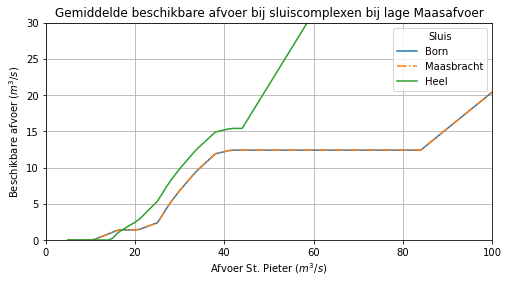

In [9]:
plt.subplots(figsize=(8,4))
plt.plot(Q_SP.index, Q['Born'], label='Born')
plt.plot(Q_SP.index, Q['Maasbracht'], label='Maasbracht', ls='-.')
plt.plot(Q_SP.index, Q['Heel'], label='Heel', ls='-')

plt.xlim(0, 100)
plt.ylim(0, 30)
plt.xlabel('Afvoer St. Pieter ($m^3/s$)')
plt.ylabel('Beschikbare afvoer ($m^3/s$)')
plt.title('Gemiddelde beschikbare afvoer bij sluiscomplexen bij lage Maasafvoer')
plt.grid()
plt.legend(title='Sluis')

plt.savefig(outputdir / 'Beschikbare_afvoer_sluiscomplexen.png', dpi=150, bbox_inches='tight')
plt.savefig(outputdir / 'Beschikbare_afvoer_sluiscomplexen.svg', bbox_inches='tight')

In [10]:
LWB = {'Maasbracht': {}, 'Born': {}, 'Heel': {}}
for lwb in Path(f'Ontwerp laagwaterbeleid/def').glob('*.csv'):
    lock = lwb.stem.split('_')[0]
    strategie = lwb.stem.split('_')[-1]
    
    LWB[lock][strategie] = pd.read_csv(lwb, index_col=0)

# for lwb in Path(f'Ontwerp laagwaterbeleid/def').glob('*.xlsx'):
#     lock = lwb.stem.split('_')[0]
#     strategie = lwb.stem.split('_')[-1]
    
#     LWB[lock][strategie] = pd.read_excel(lwb, index_col=0)


In [11]:
lock = 'Maasbracht'
strategie = 'Gelijke kosten'
klimaat = 'Ref'

scenarios = LWB[lock][strategie]
scenarios = scenarios.sort_index()  # Sorting is necessary for the interp

In [12]:
onderschrijding = Q_SP.copy()
onderschrijding.index = Q[lock]

In [13]:
def addSecond_x_axes(ax1_ticks, ax2_ticks_labels, ax2_color='#888', ax2_label=None, ax1=None, position=40):
    '''
    Add a second xlabel below the current
    
    ax1_ticks: Locations on current xaxis where markers should be placed
    ax2_ticks_labels: Labels to put at these positions
    
    ax2_color: Color of all ax2 objects
    ax2_label: xlabel
    ax1: axes to apply function on. By default uses current axes
    
    return: ax2 handle
    '''
    
    if not ax1:
        ax1=plt.gca()
        
    assert all(ax1_ticks >= ax1.get_xlim()[0]) and all(ax1_ticks <= ax1.get_xlim()[1]), 'ax1_ticks larger than xlim. Ticks: {ticks}; Limits: {limits}'.format(ticks=ax1_ticks, limits=ax1.get_xlim())
   
    ax2 = ax1.twiny()

    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom') 
    ax2.spines['bottom'].set_position(('outward', position))
    ax2.spines['bottom'].set_color(ax2_color)
    ax2.tick_params(axis='x', colors=ax2_color)

    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xticks(ax1_ticks, )
    ax2.set_xticklabels(ax2_ticks_labels)
    ax2.set_xlabel(ax2_label, color=ax2_color)
    return ax2


In [14]:
def interpolate_dataframe(df, new_index):
    # Reindex with both old and new index, interpolate to new index, and only keep new index
    f = df. \
        reindex(df.index.union(new_index)). \
        interpolate(method='index'). \
        drop_duplicates(). \
        reindex(new_index, method='ffill')  # Fill the duplicates again that were previously removed
    return f

In [15]:
def bereken_schadeperjaar(onderschrijding, scenarios):
    """
    
    returns: geinterpoleerde scenarios en totale schade per jaar
    """
    
    afvoeren = onderschrijding.index
    scenarios_interp = interpolate_dataframe(scenarios, afvoeren)
    
    schadeperjaar = pd.concat({
        'Kosten scheepvaart (mln eur)': onderschrijding.diff().multiply(scenarios_interp['Totale toename kosten scheepvaart (eur) per dag'], axis=0).sum(),
        'Pompkosten (mln eur)': onderschrijding.diff().multiply(scenarios_interp['Pompkosten (eur) per dag'], axis=0).sum()
    }, axis=1) / 1e6
    return scenarios_interp, schadeperjaar

In [16]:
scenarios_interp, schadeperjaar = bereken_schadeperjaar(onderschrijding, scenarios)

In [17]:

def add_second_legend(linestyles, colors, labels, legend2_params=None, legend1_params=None, legend_1_handle=None):
    """ 
    
    Example:
    add_second_legend(['-', ':'], colors=['k'], labels=['scenario1', 'scenario2'], legend_1_handle=legend_1_handle, legend2_params={'loc':'upper right', 'bbox_to_anchor': (0.88, 1)})

    """
    from matplotlib.lines import Line2D
    
    # If legend1 label is not given, make a legend
    if legend_1_handle is None:
        legend_1_handle = plt.legend(**legend1_params)
    
    # Colors and/or linestyles should be a sequence. If any of them is length 1, make them equal length
    if len(colors)==1: 
        colors = [colors[0] for ii in range(len(linestyles))]
        
    if len(linestyles)==1: 
        linestyles = [linestyles[0] for ii in range(len(colors))]
    
    # create manual legend
    manual_legend_lines = [Line2D([], [], linestyle=ls, color=c) for ls, c in zip(linestyles, colors)]
    
    # If no parameters are given, create empty dict
    if legend2_params is None:
        legend2_params = {}
    
    # Place legend 2, this removes legend 1
    legend_2  = plt.legend(manual_legend_lines, labels, **legend2_params)
    
    # Place legend 1 again
    plt.gca().add_artist(legend_1_handle)
    

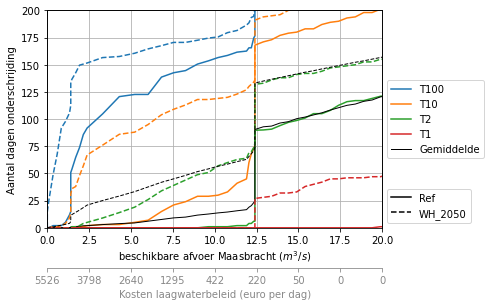

In [18]:
def plot_onderschrijding(klimaat, klimaat2=None):
    onderschrijding[klimaat].iloc[:,:-1].plot()
    onderschrijding[klimaat].iloc[:,-1].plot(c='k', lw=1, ax=plt.gca())
    legend_1_handle = plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    if klimaat2 is not None:
        onderschrijding[klimaat2].iloc[:,:-1].plot(ls='--', color=['C0', 'C1', 'C2', 'C3'], ax=plt.gca(), legend=False)
        onderschrijding[klimaat2].iloc[:,-1].plot(ls='--', c='k', lw=1, ax=plt.gca(), legend=False)
        
    
    plt.legend()
    plt.xlim(0, 20)
    plt.ylim(0., 200)
    plt.grid()
    plt.ylabel('Aantal dagen onderschrijding')
    plt.xlabel(f'beschikbare afvoer {lock} ($m^3/s$)')

    afvoer_xas = plt.gca().get_xticks()
    kosten_xas = scenarios_interp.drop_duplicates()['Totale kosten (eur) per dag'].reindex(afvoer_xas, method='ffill')
    kosten_xas_labels = [f'{s:.0f}' for s in kosten_xas]
    if klimaat2 is not None:
        add_second_legend(['-', '--'], colors=['k'], labels=[klimaat, klimaat2], legend_1_handle=legend_1_handle, legend2_params={'loc':'lower left', 'bbox_to_anchor': (1, 0)})
    else:
        plt.title(klimaat)


    addSecond_x_axes(afvoer_xas, kosten_xas_labels, ax2_label='Kosten laagwaterbeleid (euro per dag)')

# plot_onderschrijding(klimaat)
# plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{strategie}.png', dpi=150, bbox_inches='tight')
# plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{strategie}.svg', bbox_inches='tight')

plot_onderschrijding(klimaat='Ref', klimaat2='WH_2050')
# plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{klimaat2}_{strategie}.png', dpi=150, bbox_inches='tight')
# plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{klimaat2}_{strategie}.svg', bbox_inches='tight')

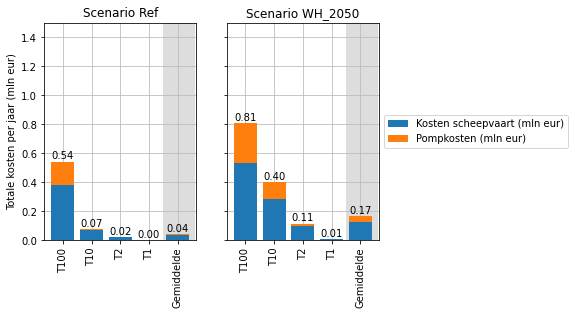

In [19]:
def plot_klimaatjaren(klimaat1='Ref', klimaat2='WH_2050'):
    f, ax = plt.subplots(ncols=2, figsize=(6,4), sharey=True)

    plt.sca(ax[0])
    schadeperjaar.loc[klimaat1].plot.bar(width=0.8, zorder=3, stacked=True, ax=ax[0], legend=False)
    plt.grid(c='#BBB')
    plt.ylabel('Totale kosten per jaar (mln eur)')
    plt.title(f'Scenario {klimaat1}')
    plt.axvspan(3.5, 4.6, facecolor='#DDD', zorder=-5)
    for i, v in enumerate(schadeperjaar.loc[klimaat1].sum(axis=1).values):
    #     if v < 0.01: continue
        plt.annotate(text=f'{v:.2f}', xy=(i, v), ha='center', xytext=(0, 3), textcoords='offset points')

    plt.sca(ax[1])
    schadeperjaar.loc[klimaat2].plot.bar(width=0.8, zorder=3, stacked=True, ax=ax[1])
    plt.grid(c='#BBB')
    plt.axvspan(3.5, 4.6, facecolor='#DDD', zorder=-5)
    plt.ylabel('Totale kosten per jaar (mln eur)')
    plt.title(f'Scenario {klimaat2}')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))


    for i, v in enumerate(schadeperjaar.loc[klimaat2].sum(axis=1).values):
        plt.annotate(text=f'{v:.2f}', xy=(i, v), ha='center', xytext=(0, 3), textcoords='offset points')

    plt.ylim(top=1.5)

plot_klimaatjaren()
# plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{strategie}.png', dpi=150, bbox_inches='tight')
# plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{strategie}.svg', bbox_inches='tight')

# Plot all

In [20]:
locks = ['Maasbracht', 'Born', 'Heel']
# locks = ['Heel']
# locks = ['Maasbracht']

for lock in locks:
    for strategie, scenarios in LWB[lock].items():
        
        
        scenarios = LWB[lock][strategie]
        scenarios = scenarios.sort_index()  # Sorting is necessary for the interp

        onderschrijding = Q_SP.copy()
        onderschrijding.index = Q[lock]

        scenarios_interp, schadeperjaar = bereken_schadeperjaar(onderschrijding, scenarios)
        
        schadeperjaar.to_csv(outputdir / f'{lock}_Kosten_per_jaar_{strategie}.csv')
        
        klimaat = 'Ref'
        klimaat2 = 'WH_2050'
        
        plot_onderschrijding(klimaat=klimaat, klimaat2=klimaat2)
        plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{klimaat2}_{strategie}.png', dpi=150, bbox_inches='tight')
        plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{klimaat2}_{strategie}.svg', bbox_inches='tight')
        plt.close()

        plot_klimaatjaren(klimaat1=klimaat, klimaat2=klimaat2)
        plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{klimaat}_{klimaat2}_{strategie}.png', dpi=150, bbox_inches='tight')
        plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{klimaat}_{klimaat2}_{strategie}.svg', bbox_inches='tight')
        plt.close()
#         for klimaat in Q_SP.columns.levels[0]:

#             plot_onderschrijding(klimaat)
#             plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{strategie}.png', dpi=150, bbox_inches='tight')
#             plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid_{klimaat}_{strategie}.svg', bbox_inches='tight')
#             plt.close()
            
#             if klimaat == 'Ref': continue

#             plot_klimaatjaren(klimaat1='Ref', klimaat2=klimaat)
#             plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{klimaat}_{strategie}.png', dpi=150, bbox_inches='tight')
#             plt.savefig(outputdir / f'{lock}_Kosten_per_jaar_{klimaat}_{strategie}.svg', bbox_inches='tight')
#             plt.close()
            
            
            
            

In [23]:
LWB_s = LWB[lock][strategie]

In [31]:
locks = ['Maasbracht', 'Born', 'Heel']

LWB_all = {}

for lock in locks:
    for strategie, scenarios in LWB[lock].items():
        LWB_s = LWB[lock][strategie]
        LWB_s = LWB_s[['index', 'Besparing debiet scheepvaart (m3/s)', 'Pompinzet (m3/s)', 'Waterbesparing door hevelend (m3/s)', 'Totale toename kosten scheepvaart (eur) per dag', 'Pompkosten (eur) per dag']]
        LWB_s.columns = ['Name', 'Q Schutregime', 'Q Pomp', 'Q Hevelend/Spaarbekken', '€ Scheepvaart', '€ Pomp']
        
        LWB_all[(lock, strategie)] = LWB_s

In [34]:
LWB_all = pd.concat(LWB_all)
LWB_all.to_excel(outputdir / 'Strategie_allemaal.xlsx')